Question 1:


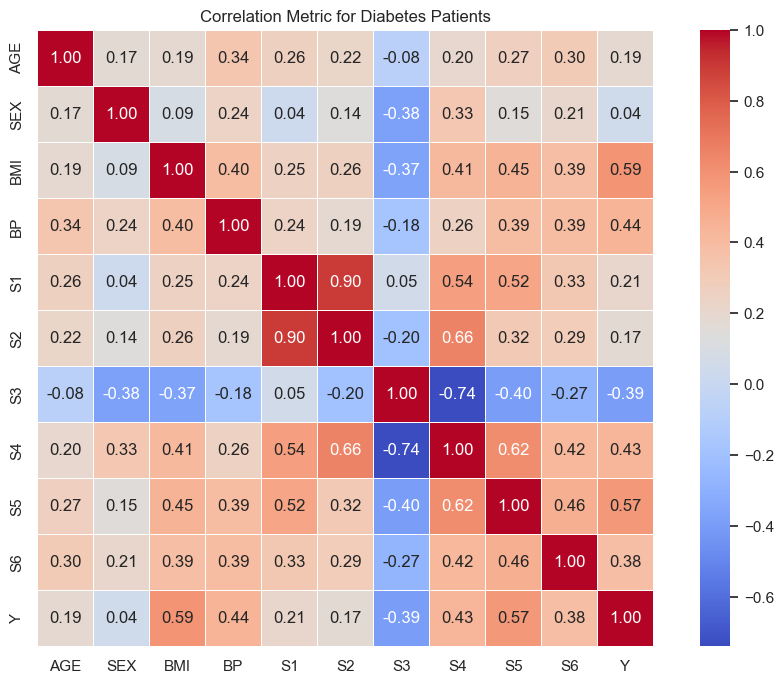

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     38.25
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           5.41e-50
Time:                        23:42:50   Log-Likelihood:                -1906.1
No. Observations:                 353   AIC:                             3834.
Df Residuals:                     342   BIC:                             3877.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -341.3782     74.073     -4.609      0.0

In [37]:
# to use read_excel function
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt
# to utilize correlation function
import numpy as np
# to utilize the fit (model) function
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


import statsmodels.api as st

def get_adjusted_r2_score(r2_score, n_observations, i_variables):
    return 1-((1-r2_score) * (n_observations-1)/(n_observations-i_variables-1))

def forwardSelection(X, y):    
    initialFeat = X.columns.tolist()
    selectedFeat = []
    
    while initialFeat:
        tempfeat = selectedFeat.copy()
        pvals = []
        
        for feature in initialFeat:
            model = st.OLS(y, st.add_constant(X[tempfeat +[feature]])).fit()
            pvals.append((model.pvalues[feature],feature))
            
        pvals.sort()
        if pvals[0][0] < 0.05:
            selectedFeat.append(pvals[0][1])
            initialFeat.remove(pvals[0][1])
        else:
            break
        
    return selectedFeat

# storing data from data source into respective data frames (both metadata and original data) 
diabetes_df = pd.read_excel('data/Diabetes_Data.xlsx')

corr = diabetes_df.corr()

sns.set(style='white')
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidth=.5)

plt.title('Correlation Metric for Diabetes Patients')
plt.show()

X= diabetes_df[['BMI', 'SEX', 'AGE','BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']]
y=diabetes_df['Y']


X_train, X_test, y_train, y_test = train_test_split(st.add_constant(X),y, test_size=0.2, random_state=42)

model = st.OLS(y_train, X_train).fit()

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions) 
print(model.summary())


print("R2: ", model.rsquared)
print("Adjusted R2: ", model.rsquared_adj)
print("Mean Squared Error: ", mse)
# print("R-Squared: ", r2)
# print("Adj-R-Squared: ", get_adjusted_r2_score(r2, len(y_test), X_test.shape[1]))


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.head())
X= diabetes_df.drop('Y', axis=1)
y = diabetes_df['Y']

# run forward selection
selectVariables = forwardSelection(X_train,y_train)
print("Selected Variables:", selectVariables)
X_train= st.add_constant(X_train[selectVariables])
# fit final model with selected variables
finalModel = st.OLS(y_train, X_train).fit()

mse = finalModel.mse_model
r_squared = finalModel.rsquared

print(finalModel.summary())

X_test= st.add_constant(X_test[selectVariables])
predictions = finalModel.predict(X_test)

# r2 = r2_score(y_test, predictions)

print(f"New model Statistics: \n")
print(f"R-squared: {r_squared:.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, predictions)}")
# print(f"R-squared: {r2}")
print("Adj-R-Squared: ", get_adjusted_r2_score(r_squared, len(y_test), X_test.shape[1]))
# print("Adj-R-Squared: ", get_adjusted_r2_score(r2, len(y_test), X_test.shape[1]))



Question 2:


In [33]:
# to utilize the plot function 
import pandas as pd
# to plot and configure graphs
import matplotlib.pyplot as plt

# to utilize the OLS
import statsmodels.api as st 

from sklearn.feature_selection import RFE

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, f1_score, recall_score

from sklearn.metrics import confusion_matrix

# reading data from csv file
titan_df = pd.read_csv('data/titanic3.csv')
# print(titan_df) 


t_passengers = titan_df.shape[0]
t_survivors = titan_df['survived'].sum()

prob_of_survival = t_survivors / t_passengers
print(f"Probability of Survival: {prob_of_survival}")

# group by passenger class and gender 
survival_probabilities = (
    titan_df.groupby(['pclass', 'sex'])
        .agg(Total=('survived', 'count'),
    Survived=('survived', 'sum'))
        .reset_index()
)


# calculate survival probability
survival_probabilities['Survival Probability (%)'] = (survival_probabilities['Survived'] / survival_probabilities['Total']) * 100

# format table
r_table = survival_probabilities[['pclass', 'sex', 'Survival Probability (%)']]
r_table = r_table.rename(columns={'sex': 'gender'})

print(r_table)

# survival_by_pclass = titan_df.groupby('pclass')['survived'].mean().reset_index()
# survival_by_pclass.columns = ['Passenger Class', 'Survival Probability']
# survival_by_gender = titan_df.groupby('sex')['survived'].mean().reset_index()
# survival_by_gender.columns = ['Sex', 'Survival Probability']

# titan_df['age_group'] = pd.cut(titan_df['age'], bins=[0,12,60,100], labels=['Children (0-12)', 'Adults (13-60)', 'Seniors (60+)'])
# survival_by_age_group = titan_df.groupby('age_group')['survived'].mean().reset_index()
# survival_by_age_group.columns = ['Age Group', 'Survival Probability']

# print("\nSurvival Probability by Survival Probability:")
# print(survival_by_pclass)

# print("\nSurvival Probability by Gender:")
# print(survival_by_gender)

# print("\nSurvival Probability by Age Group:")
# print(survival_by_age_group)


# data preprocessing 

median_age = titan_df['age'].median()
titan_df['age'] = titan_df['age'].fillna(median_age)

mode_fare = titan_df['fare'].mean()
titan_df['fare'] = titan_df['fare'].fillna(mode_fare)

# titan_df.describe()

# titan_df = pd.get_dummies(titan_df, columns=['sex'], drop_first=True)
titan_df['sex'] = titan_df['sex'].map({'female':0, 'male':1})
# titan_df = pd.get_dummies(titan_df, columns=['pclass'])

# X = titan_df[['age'] + [col for col in titan_df.columns if 'sex_' in col or 'pclass_' in col]]
X = titan_df[['age', 'sex', 'pclass', 'fare', 'sibsp', 'parch']]

# allcols = ['age', 'sex', 'fare', 'pclass',"passenger_id", "name", "sibsp", "parch", "ticket", "cabin", "embarked", "body", "home.dest"]
y=titan_df['survived'].astype(int)


# logistic regression model
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=42)

# create and fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# prediction on test data 
y_pred = model.predict(X_test)

# prediction for verification
# print("Predictions: \n", y_pred)

coefficients = model.coef_[0]
intercept = model.intercept_[0]

# odds ratio
odds_ratios = np.exp(coefficients)


X_with_intercept = st.add_constant(X_train)                 # adding intercept for statsmodels
np.asarray(X_with_intercept)
logit_model = st.Logit(y_train, X_with_intercept)
result = logit_model.fit()
print(result.summary())


# summary_table = pd.DataFrame({
#     'Coefficent': [intercept] + list(X.columns),
#     'Predictor': ['Intercept'] + list(coefficients),
#     'Odds_Ratio': [np.exp(intercept)] + list(odds_ratios),
#     'P_Value':[logit_model.pvalues[0]] + list(logit_model.pvalues[1:]) 
# })

# summary_table.reset_index(inplace=True)
# summary_table.rename(columns={'index':'Predictor'}, inplace=True)

# probabilities predictions on test set
predictions = model.predict_proba(X_test)[:,1]

# predicting class labels based on a threshold (default is 0.5)
y_pred = (predictions >= 0.5).astype(int)

# calculating evaluation matrix
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, predictions)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Scores below are on test set:")
print(f'Accuracy: {accuracy:.2f}')
print(f'AUC Score: {auc_score:.2f}')
print(f'precision_score: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall Score: {recall:.2f}')

report = classification_report(y_test, np.where(predictions > 0.5, 1, 0))
print(report)

# print(model.summary())


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)





Probability of Survival: 0.3819709702062643
   pclass  gender  Survival Probability (%)
0       1  female                 96.527778
1       1    male                 34.078212
2       2  female                 88.679245
3       2    male                 14.619883
4       3  female                 49.074074
5       3    male                 15.212982
Optimization terminated successfully.
         Current function value: 0.456872
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1047
Model:                          Logit   Df Residuals:                     1040
Method:                           MLE   Df Model:                            6
Date:                Mon, 04 Nov 2024   Pseudo R-squ.:                  0.3037
Time:                        23:32:25   Log-Likelihood:                -478.34
converged:                       True   LL-Null:                       -